# The Automated Data Scientist: Tools for Feature and Model Discovery
by Matthew Emery

In [32]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import featuretools as ft
from random import sample
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from category_encoders import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, confusion_matrix, matthews_corrcoef
import warnings
from itertools import chain
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from IPython.core.debugger import set_trace
from tpot import TPOTClassifier, config
from hpsklearn import HyperoptEstimator, xgboost_classification
%matplotlib inline

warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("data/train.csv")
target = df["Survived"]
features = df.drop(columns=["Survived", "PassengerId"])
features['Pclass'] = features['Pclass'].astype('category')

(train_features, test_features, 
 train_target, test_target) = train_test_split(
    features, target, train_size=0.75, stratify=target,
    random_state=0)

train_features.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
671,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.000,B71,S
417,2,"Silven, Miss. Lyyli Karoliina",female,18.0,0,2,250652,13.000,NaN,S
634,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.900,NaN,S
323,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.000,NaN,S
379,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.775,NaN,S


## Dataset Used: Titanic
- Doing a 3:1 train/validation split, stratified
- Set random_state to reproduce results

In [15]:
basic_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
basic_test_features = test_features.drop(columns=["Name", "Ticket", "Cabin"])

dummy_model = make_pipeline(OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked']), 
                            DummyClassifier(random_state=0))
dummy_cv = cross_val_score(dummy_model, basic_features, train_target, cv=5)
dummy_cv.mean(), dummy_cv.std()

(0.5523306608145571, 0.02692920393571968)

## Setting a Baseline
- It's always a good idea to know where the bar is
- sklearn.dummy.DummyClassifier chooses randomly based on class distribution

In [9]:
basic_model = make_pipeline(OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked']),
                            XGBClassifier(random_state=0))
basic_cv = cross_val_score(basic_model, 
                           basic_features, 
                           train_target, 
                           cv=5)
basic_cv.mean(), basic_cv.std()

(0.8277599471315105, 0.025211333900729473)

## No Feature Engineering
- I'm not using the sklearn implementation of OneHotEncoder
- Check out `category_encoders`
- Overall, this is a pretty good result, can we increase it?

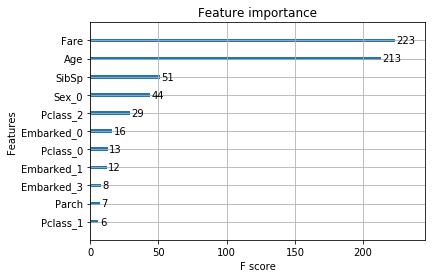

In [58]:
plot_importance(basic_model.named_steps['xgbclassifier'])

In [56]:
one_hot = OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked'])
one_hot_features = one_hot.fit_transform(basic_features)
column_names = one_hot_features.columns
imputer = Imputer(strategy="median")
one_hot_features = imputer.fit_transform(one_hot_features)
xgb = XGBClassifier(random_state=0)
xgb.fit(one_hot_features, train_target)
perm_imp = PermutationImportance(xgb).fit(one_hot_features, train_target)
show_weights(perm_imp, feature_names = column_names.values.tolist())

Weight,Feature
0.2141 ± 0.0142,Sex_0
0.0982 ± 0.0178,Age
0.0970 ± 0.0194,Pclass_2
0.0707 ± 0.0154,Fare
0.0216 ± 0.0094,SibSp
0.0078 ± 0.0052,Pclass_0
0.0024 ± 0.0015,Parch
0.0018 ± 0.0012,Embarked_1
0.0012 ± 0.0012,Pclass_1
0.0009 ± 0.0041,Embarked_3


## Feature Importance
- Fare and Age seem important
- Be cautious, we don't know *why* they are yet
- The default implementation will underestimate the importance of categorical features
- PermutationImportance can be found in `eli5`

In [59]:
ft_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=ft_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

2018-04-23 16:10:23,866 featuretools.entityset - WARNING    index PassengerId not found in dataframe, creating new integer column


Entityset: titanic
  Entities:
    titanic (shape = [668, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

## Featuretools Intro
- Featuretools builds automatically generates features
- Group attributes by categories and run aggregate functions
- Requires you create an Entity Set, similar to a SQL Database

In [60]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.head(5)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,embarkeds.MEAN(titanic.Parch),embarkeds.MEAN(titanic.Fare),embarkeds.COUNT(titanic),embarkeds.NUM_UNIQUE(titanic.Pclass),embarkeds.NUM_UNIQUE(titanic.Sex),embarkeds.MODE(titanic.Pclass) = 3.0,embarkeds.MODE(titanic.Pclass) = 1.0,embarkeds.MODE(titanic.Pclass) = unknown,embarkeds.MODE(titanic.Sex) = male,embarkeds.MODE(titanic.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
0,31.0,1,0,52.000,0,1,0,0,1,0,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
1,18.0,0,2,13.000,0,0,1,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
2,9.0,3,2,27.900,1,0,0,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
3,22.0,1,1,29.000,0,0,1,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
4,19.0,0,0,7.775,1,0,0,0,1,0,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0


## Deep Feature Synthesis
- Featuretools calls it's process deep feature synthesis
- These is fancy talk for nested group bys and numpy operations
- You can make your own primitives
- The encode feature operation acts like a OneHotEncoder

In [64]:
sample(features, 5), len(features)

([<Feature: classes.MAX(titanic.SibSp)>,
  <Feature: Embarked = unknown>,
  <Feature: embarkeds.SUM(titanic.Age)>,
  <Feature: classes.MAX(titanic.Age)>,
  <Feature: sexes.MAX(titanic.Parch)>],
 109)

In [63]:
ft_cv = cross_val_score(XGBClassifier(random_state=0), feature_matrix, train_target, cv=5)
ft_cv.mean(), ft_cv.std()

(0.8262784656500288, 0.024850913107283185)

- That sucks. We've added dozens of features and the accuracy didn't go up
- It actually gets worse

In [65]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.features = None
        
    def fit(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        _, self.features = ft.encode_features(entity_set, features)
        return self

    def transform(self, X, y=None):
        if not self.features:
            raise ValueError("Fit the FeaturetoolsTransformer first")
        else:
            entity_set = self._create_entity(X)
            df = ft.calculate_feature_matrix(self.features, entityset=entity_set)
            return df.reindex(X.index)
        
    def fit_transform(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        df, self.features = ft.encode_features(entity_set, features)
        return df.reindex(X.index)
        
    def _create_entity(self, X):
        X = X.reset_index()
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index = "index",
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        return es

## Data Leakage
- Did you know you can make your own scikit-learn transformer?
- ANY interaction between your train and validation sets is data leakage!
- This includes imputation and feature engineering
- This also include cross-validation

In [68]:
ft_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"]),
    XGBClassifier(random_state=0))

ft_cv = cross_val_score(ft_pipeline, ft_features, train_target, cv=5)
ft_cv.mean(), ft_cv.std()

(0.8202634280560439, 0.032002366990625905)

This is only a slight drop, but we should proceed with caution

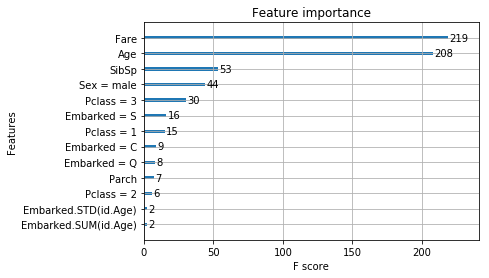

In [69]:
ft_pipeline.fit(ft_features, train_target)
plot_importance(ft_pipeline.named_steps['xgbclassifier'])

In [77]:
feature_matrix_importance = PermutationImportance(XGBClassifier(random_state=0), cv=5)
feature_matrix_importance.fit(feature_matrix, train_target)


Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass = 3', 'Pclass = 1',
       'Pclass = 2', 'Pclass = unknown', 'Sex = male', 'Sex = female',
       ...
       'embarkeds.MEAN(titanic.Parch)', 'embarkeds.MEAN(titanic.Fare)',
       'embarkeds.COUNT(titanic)', 'embarkeds.NUM_UNIQUE(titanic.Pclass)',
       'embarkeds.NUM_UNIQUE(titanic.Sex)',
       'embarkeds.MODE(titanic.Pclass) = 3.0',
       'embarkeds.MODE(titanic.Pclass) = 1.0',
       'embarkeds.MODE(titanic.Pclass) = unknown',
       'embarkeds.MODE(titanic.Sex) = male',
       'embarkeds.MODE(titanic.Sex) = unknown'],
      dtype='object', length=109)


In [76]:
train_features['CabinClass'] = train_features["Cabin"].str.get(0)
train_features['LastName'] = train_features['Name'].str.split(", ").apply(lambda x: x[0])
train_features['Honorific'] = train_features['Name'].str.extract(" ([a-zA-z]+)")
train_features['TicketPrefix'] = train_features['Ticket'].str.extract("(.+) ")
train_features = train_features.drop(columns=["Name", "Cabin", "Ticket"])

In [145]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 270 features
Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,ticketprefixes.MODE(titanic.LastName) = Corn,ticketprefixes.MODE(titanic.LastName) = Hakkarainen,ticketprefixes.MODE(titanic.LastName) = unknown,ticketprefixes.MODE(titanic.Honorific) = Mr,ticketprefixes.MODE(titanic.Honorific) = Miss,ticketprefixes.MODE(titanic.Honorific) = Master,ticketprefixes.MODE(titanic.Honorific) = Capt,ticketprefixes.MODE(titanic.Honorific) = Rev,ticketprefixes.MODE(titanic.Honorific) = Mrs,ticketprefixes.MODE(titanic.Honorific) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
744,24.0,1,0,16.1000,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
359,NaN,0,0,7.8792,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
273,41.0,0,1,19.5000,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
487,35.0,1,0,90.0000,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
143,24.0,1,0,15.8500,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


In [84]:
fte_transformer = FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"])
transformed_extended_features = fte_transformer.fit_transform(train_features)
fte_cv = cross_val_score(XGBClassifier(random_state=0), transformed_extended_features, train_target, cv=5)
fte_cv.mean(), fte_cv.std()

(0.8263121319052191, 0.011519745551586162)

In [85]:
fte_pipeline = make_pipeline(FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"]),
                             XGBClassifier(random_state=0))

In [ ]:
expanded_ft_cv = cross_val_score(fte_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5)
expanded_ft_cv.mean(), expanded_ft_cv.std()

(0.7499681209657644, 0.08466659870704168)

In [ ]:
picky_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                    "Sex", 
                                                    "Embarked", 
                                                    "CabinClass",
                                                    "LastName",
                                                    "Honorific",
                                                    "TicketPrefix"]),
    Imputer(strategy='median'),
    RFECV(XGBClassifier(random_state=1), 
          cv=5, 
          step=0.05,
         n_jobs=-1),
    XGBClassifier(random_state=0, n_jobs=-1)
)

selected_ft_cv = cross_val_score(picky_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5)
selected_ft_cv.mean(), selected_ft_cv.std()

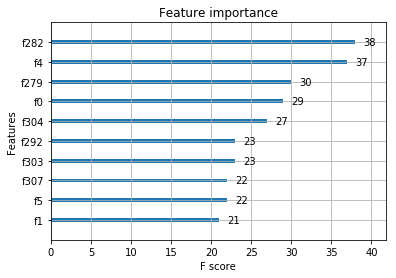

In [198]:
picky_pipeline.fit(train_features, train_target)
plot_importance(picky_pipeline.named_steps['xgbclassifier'], max_num_features=10)

In [14]:
basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv

(array([0.78888889, 0.82222222, 0.7752809 , 0.84269663, 0.88764045,
        0.80898876, 0.83146067, 0.76404494, 0.82022472, 0.85227273]),
 array([0.78888889, 0.85555556, 0.7752809 , 0.83146067, 0.8988764 ,
        0.83146067, 0.83146067, 0.7752809 , 0.82022472, 0.84090909]),
 array([0.78888889, 0.81111111, 0.79775281, 0.86516854, 0.86516854,
        0.80898876, 0.84269663, 0.82022472, 0.82022472, 0.86363636]),
 array([0.76666667, 0.82222222, 0.79775281, 0.85393258, 0.86516854,
        0.82022472, 0.86516854, 0.80898876, 0.83146067, 0.84090909]))

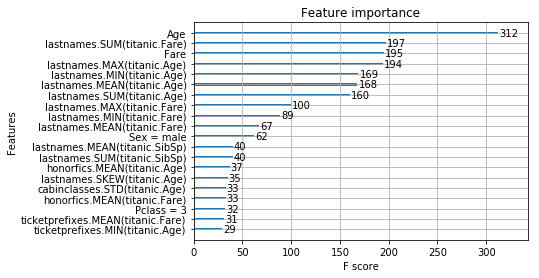

In [15]:
basic_model.fit(feature_matrix, train_target)
plot_importance(basic_model, max_num_features=20)

In [201]:
hpe_pipeline = make_pipeline(FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"]),
                             HyperoptEstimator(classifier=xgboost_classification(name='xgb'),
                                               seed=0))

In [202]:
hpe_cv = cross_val_score(hpe_pipeline, 
                         train_features, 
                         train_target, 
                         cv=5)
hpe_cv.mean(), hpe_cv.std()

AttributeError: 'NoneType' object has no attribute 'uniform'

In [16]:
df = pd.DataFrame(
    {"Model": list(chain.from_iterable([[x] * 10 for x in ("Basic Features", 
                                                           "Naive Featuretools",
                                                           "Smarter Featuretools",
                                                           "Selected Featuretools")])),
        "CV Fold Accuracy": np.concatenate([basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv])} )

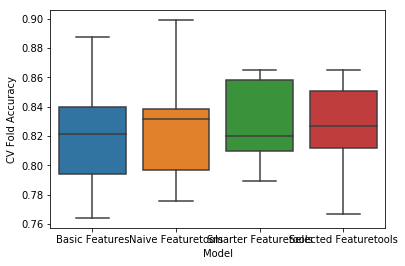

In [17]:
sns.boxplot("Model", "CV Fold Accuracy", data = df)

In [138]:
## Talk about TPOT
ft_config_dict = {'FeaturetoolsTransformer': {'categorical_features' : 
                  [["Pclass", "Sex", "Embarked", "CabinClass", 
                     "LastName", "Honorific", "TicketPrefix"]]}
}
custom_config_dict = {**ft_config_dict, **config.classifier.classifier_config_dict}

In [151]:
tpot = TPOTClassifier(periodic_checkpoint_folder="results/checkpoints", 
                      cv = 5, 
                      verbosity=2, 
                      n_jobs=-1,
                      generations=10,
                      population_size=10)

In [152]:
tpot.fit(feature_matrix, target=train_target)

Imputing missing values in feature set


Optimization Progress:  18%|█▊        | 20/110 [01:18<23:29, 15.66s/pipeline]

Generation 1 - Current best internal CV score: 0.8215848572959589


Optimization Progress:  28%|██▊       | 31/110 [01:40<12:40,  9.62s/pipeline]

Generation 2 - Current best internal CV score: 0.8294374716955571


Optimization Progress:  37%|███▋      | 41/110 [01:55<06:22,  5.54s/pipeline]

Generation 3 - Current best internal CV score: 0.8294374716955571


Optimization Progress:  46%|████▋     | 51/110 [04:57<13:47, 14.02s/pipeline]

Generation 4 - Current best internal CV score: 0.8373153362292968


Optimization Progress:  55%|█████▌    | 61/110 [07:55<34:07, 41.79s/pipeline]

Generation 5 - Current best internal CV score: 0.8373153362292968


Optimization Progress:  65%|██████▌   | 72/110 [13:18<53:58, 85.22s/pipeline]   

Generation 6 - Current best internal CV score: 0.8373153362292968


Optimization Progress:  75%|███████▍  | 82/110 [16:13<22:07, 47.40s/pipeline]

Generation 7 - Current best internal CV score: 0.8373153362292968


Optimization Progress:  84%|████████▎ | 92/110 [17:40<06:24, 21.34s/pipeline]

Generation 8 - Current best internal CV score: 0.8373153362292968


Optimization Progress:  93%|█████████▎| 102/110 [19:01<03:01, 22.71s/pipeline]

Generation 9 - Current best internal CV score: 0.8373153362292968


Generation 10 - Current best internal CV score: 0.8373153362292968

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=13, min_samples_split=10, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=10, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=4,
        offspring_size=10,
        periodic_checkpoint_folder='results/checkpoints',
        population_size=10, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,LastName,Honorific,TicketPrefix
0,1,3,male,22.0,1,0,7.2500,S,NaN,Braund,Mr,A/5
1,2,1,female,38.0,1,0,71.2833,C,C,Cumings,Mrs,PC
2,3,3,female,26.0,0,0,7.9250,S,NaN,Heikkinen,Miss,STON/O2.
3,4,1,female,35.0,1,0,53.1000,S,C,Futrelle,Mrs,NaN
4,5,3,male,35.0,0,0,8.0500,S,NaN,Allen,Mr,NaN
5,6,3,male,NaN,0,0,8.4583,Q,NaN,Moran,Mr,NaN
6,7,1,male,54.0,0,0,51.8625,S,E,McCarthy,Mr,NaN
7,8,3,male,2.0,3,1,21.0750,S,NaN,Palsson,Master,NaN
8,9,3,female,27.0,0,2,11.1333,S,NaN,Johnson,Mrs,NaN
9,10,2,female,14.0,1,0,30.0708,C,NaN,Nasser,Mrs,NaN
